In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
from rich.console import Console

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.9 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [2]:
#--- argparser
parser = argparse.ArgumentParser()
parser.add_argument('--cfg', type=str, default='/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/configs/finetune.yaml')
args = parser.parse_args(args=[])
cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))


In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
if cfg.SAMPLE:
    parse_idx = int(len(names_data) * 0.01)
    names_data = names_data[:parse_idx]
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [4]:
if cfg.TIMM: 
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )
    
    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    #logger.info(data_config)
    #logger.info(data_transform) 

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [5]:
ckpt_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/eva_large_patch14_336.in22k_ft_in22k_in1k_epoch_6.pth"
model.load_state_dict(torch.load(ckpt_path))

<All keys matched successfully>

In [6]:
if cfg.TIMM:
    train_set = map_dataset.Map_Dataset_v1(names_train,train_path,max_size=data_config['input_size'][1]) 
    valid_set = map_dataset.Map_Dataset_v1(names_valid,train_path,max_size=data_config['input_size'][1])  
else:
    train_set = map_dataset.Map_Dataset_v1(names_train,train_path,max_size=cfg.IMAGE_SIZE[0]) 
    valid_set = map_dataset.Map_Dataset_v1(names_valid,train_path,max_size=cfg.IMAGE_SIZE[0])

In [7]:
print(train_set.__getitem__(0)[0].shape)
print(train_set.__getitem__(0)[1])

torch.Size([3, 336, 336])
0


Label :  6
Prediction :  tensor([6], device='cuda:3')


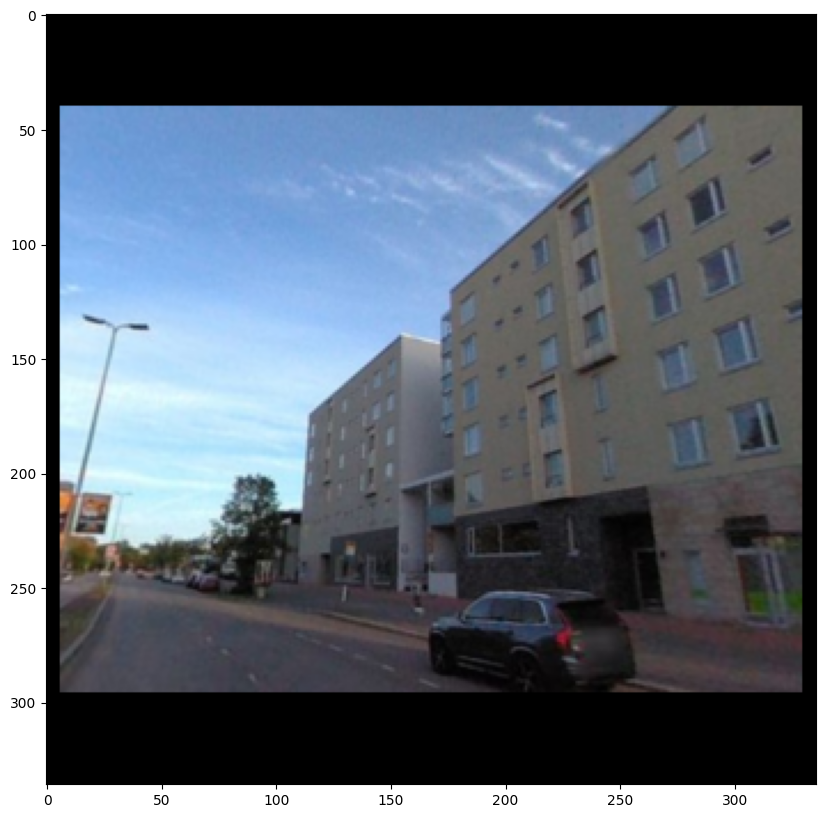

In [8]:
#--- Single image for Visualization 

import random
idx_ = random.randint(0,999)
img_torch = train_set.__getitem__(idx_)[0]
RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"

model = model.to(device)
img_torch = img_torch.to(device)
model.eval()
img_torch = img_torch.unsqueeze(0)
preds = model(img_torch)
preds = preds.argmax(1)

print("Label : ",train_set.__getitem__(idx_)[1])
print("Prediction : ", preds)

In [9]:
TrainLoader = DataLoader(train_set,8)
ValidLoader = DataLoader(valid_set,8)

In [10]:
# from tqdm import tqdm
# from sklearn.metrics import precision_recall_fscore_support


# #-- Loader train/valid
# Loader = TrainLoader
# #--
# labels_ = []
# predictions_ = []
# for batch in tqdm(Loader):
#     imgs = batch[0].to(device)
#     lables = batch[1]
#     batch_preds = model(imgs)
#     predictions = torch.argmax(batch_preds,-1)
    
#     #-- 
#     predictions_.append(predictions.cpu())
#     labels_.append(lables)
     
#     #cnt+=1 
    
#     # if cnt == 2:
#     #     break

In [11]:
# # F1 Score 

# precision_ = 0
# recall_=0
# f1_ =0
# for i in tqdm(range(len(labels_))):
#     precision, recall, f1, _ = precision_recall_fscore_support(labels_[i], predictions_[i], average='weighted')
    
#     precision_ += precision
#     recall_ += recall
#     f1_ += f1
# precision_ = precision_ / len(labels_)
# recall_ = recall_ / len(labels_)
# f1_ = f1_ / len(labels_)

# print(precision_,recall,f1_)
    

In [12]:
from tqdm import tqdm

device = "cuda:2"
model = model.to(device)

#-- Loader train/valid
Loader = ValidLoader
#--
labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[0].to(device)
    lables = batch[1]
    batch_preds = model(imgs)
    predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(predictions.cpu())
    labels_.extend(lables)

100%|██████████| 386/386 [01:52<00:00,  3.43it/s]


In [13]:
len(labels_)

3085

In [14]:
len(predictions_)

3085

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(labels_, predictions_, average='weighted')
accuracy = accuracy_score(labels_, predictions_)

In [16]:
precision

0.6950180538642095

In [17]:
recall

0.6965964343598056

In [18]:
f1

0.6956370055783232

In [21]:
accuracy

0.6965964343598056